<a href="https://colab.research.google.com/github/BYRic-F/Data_practice/blob/main/FB_Checkpoint_3_Data_Analyst_Sept_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Les durées sont indicatives et dépendent évidemment de chaque personne.Si vous voyez que vous ne pouvez pas terminer un exercice à temps, n'hésitez pas à passer à l'exercice suivant.

Si vous n'avez pas le temps de tout terminer, vous pouvez recommencer ce week-end ou la semaine prochaine. Vous indiquerez simplement dans les commentaires les scripts que vous avez terminés par la suite.

# Partie 1 - API - Environ 1h

L'ensemble de données suivant répertorie une sélection des meilleurs restaurants de Paris, à des prix très abordables (moins de 15 euros par menu en moyenne).

In [161]:
import pandas as pd

food_paris = pd.read_csv("https://raw.githubusercontent.com/WildCodeSchool/wilddata/main/food.csv").drop(columns = "Unnamed: 0")

In [162]:
import requests
import folium

In [163]:
food_paris.head()

,nom,adresse,code postal
0,Kodawari Tsukiji,12 Rue de Richelieu,75001 Paris
1,Café Lai’Tcha,7 Rue du Jour,75001 Paris
2,Pizz'Aria,55 Rue Montmartre,75002 Paris
3,M La Vie,85 Rue Montmartre,75002 Paris
4,Road Trip,36 Rue Poissonnière,75002 Paris


In [164]:
food_paris.shape

(29, 3)

Utilisez cette [API](https://data.geopf.fr/geocodage/openapi), pour récupérer des points de coordonnées (lon, lat).

In [165]:
#1er test avec une seule adresse pour comprendre la construction de l'API
base = "https://data.geopf.fr/geocodage/search/"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Referer': 'https://www.example.com'
}

# Api uniquement limité aux adresses postales
params = {'q' : "12 Rue de Richelieu	75001 Paris",
          'format' : 'json'}

response = requests.get(base, params = params, headers= headers )
r= response.json()
r


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [2.336258, 48.864374]},
   'properties': {'label': '12 Rue de Richelieu 75001 Paris',
    'score': 0.9659081818181818,
    'housenumber': '12',
    'id': '75101_8212_00012',
    'name': '12 Rue de Richelieu',
    'postcode': '75001',
    'citycode': '75101',
    'x': 651306.61,
    'y': 6862909.38,
    'city': 'Paris',
    'district': 'Paris 1er Arrondissement',
    'context': '75, Paris, Île-de-France',
    'type': 'housenumber',
    'importance': 0.62499,
    'street': 'Rue de Richelieu',
    '_type': 'address'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [2.336521, 48.864671]},
   'properties': {'label': 'Passage de Richelieu 75001 Paris',
    'score': 0.6120327272727272,
    'id': '75101_8211',
    'name': 'Passage de Richelieu',
    'postcode': '75001',
    'citycode': '75101',
    'x': 651326.18,
    'y': 6862942.24,
    'city': 'Paris',
    

In [166]:
lon = r['features'][0]['geometry']['coordinates'][0]
lat = r['features'][0]['geometry']['coordinates'][1]
print(lon, lat )

2.336258 48.864374


In [167]:
#Test fusion des 2 colonnes
food_paris['adresse'][0] + ' ' + food_paris['code postal'][0]

'12 Rue de Richelieu 75001 Paris'

In [168]:
#Création d'une fonction
def lat_lon(row) :
  base = "https://data.geopf.fr/geocodage/search/"
  headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
      'Referer': 'https://www.example.com'
  }

  # Api uniquement limité aux adresses postales
  params = {'q' : f"{row['adresse'] +' '+ row['code postal']}",
            'format' : 'json'}

  response = requests.get(base, params = params, headers= headers )
  r= response.json()
  return (r['features'][0]['geometry']['coordinates'][1] , r['features'][0]['geometry']['coordinates'][0])


liste_coordonnees = food_paris.apply(lat_lon, axis = 1)
liste_coordonnees.head(5)

,0
0,"(48.864374, 2.336258)"
1,"(48.86355, 2.344247)"
2,"(48.865983, 2.344484)"
3,"(48.867596, 2.343757)"
4,"(48.869951, 2.34794)"


Mettez ces coordonnées dans une colonnes dans votre DataFrame `food_paris`

In [169]:
# Application de la fonction
food_paris['coordonnees_lat_lon'] = food_paris.apply(lat_lon, axis = 1)
food_paris['latitude'] = food_paris['coordonnees_lat_lon'].apply(lambda x : x[0])
food_paris['longitude'] = food_paris['coordonnees_lat_lon'].apply(lambda x : x[1])


In [170]:
food_paris.head(5)

,nom,adresse,code postal,coordonnees_lat_lon,latitude,longitude
0,Kodawari Tsukiji,12 Rue de Richelieu,75001 Paris,"(48.864374, 2.336258)",48.864374,2.336258
1,Café Lai’Tcha,7 Rue du Jour,75001 Paris,"(48.86355, 2.344247)",48.863550,2.344247
2,Pizz'Aria,55 Rue Montmartre,75002 Paris,"(48.865983, 2.344484)",48.865983,2.344484
3,M La Vie,85 Rue Montmartre,75002 Paris,"(48.867596, 2.343757)",48.867596,2.343757
4,Road Trip,36 Rue Poissonnière,75002 Paris,"(48.869951, 2.34794)",48.869951,2.347940


# Folium

Affichez maintenant ces restaurants sur une carte, en utilisant la bibliothèque `folium`.

In [171]:
# Centrage de la map

m = folium
point = [float(food_paris['latitude'][1]), float(food_paris['longitude'][1])]

m = folium.Map(location=point,zoom_start=13)

# BOucle sur les coordonnées pour l'affichage des coordonnées de chaque restau sur la carte
for id in range(food_paris.shape[0]) :
  folium.Marker( location = food_paris.loc[id, 'coordonnees_lat_lon'],
                popup = folium.Popup(f"Nom : {food_paris.loc[id, 'nom']}")).add_to(m)
m

m

# Tri et regroupement

Afficher un classement descendant, compte tenu du nombre de restaurants par code postal.

In [172]:
classement = food_paris.groupby('code postal').size().reset_index().rename(columns = { 0 : "number_restaurant"}).sort_values('number_restaurant', ascending= False)
classement['code postal'] = classement['code postal'].str[:5]
classement

,code postal,number_restaurant
1,75002,5
7,75009,4
8,75010,4
9,75011,3
3,75004,2
2,75003,2
0,75001,2
4,75006,2
6,75008,2
5,75007,1


# Partie 2 - Exploration et traitement des données - Python & Pandas - environ 30 min

Exécutez le code ci-dessous.Vous obtiendrez un DataFrame avec 10 000 commentaires de restaurant.
- Date: la date du commentaire
- Stars: La note (de 1 à 5)
- Texte: le texte du commentaire
- Useful: le nombre d'utilisateurs qui ont indiqué ce commentaire comme "utile"
- Sentiment: le mot "bon" ou "mauvais" selon la note des étoiles

L'objectif de ces pièces sera d'explorer cet ensemble de données, puis de proposer un modèle de prédiction de notation positive selon les autres fonctionnalités.

Commencez par vérifier qu'il n'y a pas de valeurs manquantes.

In [77]:
import pandas as pd
df_restaurants = pd.read_csv("https://github.com/WildCodeSchool/wilddata/raw/main/restaurant.zip", index_col='Unnamed: 0').loc[:,["date", "stars", "text", "useful"]]
df_restaurants["sentiment"] = df_restaurants["stars"].apply(lambda x: "bad" if x <=3 else "good")
df_restaurants

,date,stars,text,useful,sentiment
0,2011-01-26,5,My wife took me here on my birthday for breakf...,5,good
1,2011-07-27,5,I have no idea why some people give bad review...,0,good
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,1,good
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",2,good
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,good
...,...,...,...,...,...
9995,2012-07-28,3,First visit...Had lunch here today - used my G...,2,bad
9996,2012-01-18,4,Should be called house of deliciousness!\n\nI ...,0,good
9997,2010-11-16,4,I recently visited Olive and Ivy for business ...,0,good
9998,2012-12-02,2,My nephew just moved to Scottsdale recently so...,0,bad


In [78]:
# Vérification des valeurs manquantes
df_restaurants.isna().sum()

,0
date,0
stars,0
text,0
useful,0
sentiment,0


## colonne "texte"

Utilisez **Apply** pour créer une nouvelle colonne `len_text`, indiquant la longueur (nombre de caractères) de chaque commentaire.

Afficher un histogramme et un `boxplot` pour représenter la distribution de cette colonne `len_text`.Les valeurs sont-elles bien distribuées?La plupart des commentaires sont-ils longs ou courts?

In [79]:
#Application d'une fonction lambda simple
df_restaurants['len_text'] = df_restaurants['text'].apply(lambda x: len(x))
df_restaurants.head(5)

,date,stars,text,useful,sentiment,len_text
0,2011-01-26,5,My wife took me here on my birthday for breakf...,5,good,889
1,2011-07-27,5,I have no idea why some people give bad review...,0,good,1345
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,1,good,76
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",2,good,419
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,good,469


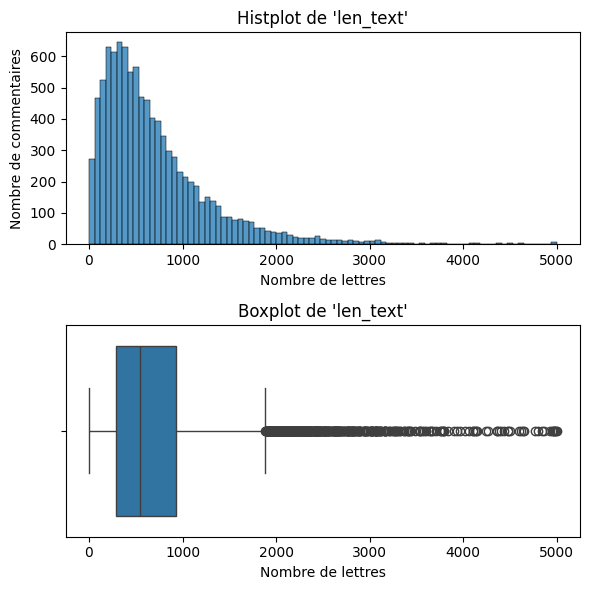

In [80]:
# Affichage boxplot
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(2, figsize= (6,6))
sns.histplot(data= df_restaurants, x = "len_text", ax = axes[0])
axes[0].set_title("Histplot de 'len_text'")
axes[0].set_xlabel("Nombre de lettres")
axes[0].set_ylabel("Nombre de commentaires")

sns.boxplot(data = df_restaurants, x= "len_text", ax = axes[1])
axes[1].set_title("Boxplot de 'len_text'")
axes[1].set_xlabel("Nombre de lettres")

plt.tight_layout()
plt.show()

Grace à l'histogramme, nous voyons que nous avons une distribution asymétrique à droite.

La plupart des commentaires sont plutot cours (75% des commentaires sont inférieurs à 1000 lettres.

## Colonne "Stars"

- Afficher un diagramme de dispersion pour comparer la colonne `utile` et la colonne `stars`.Pensez-vous qu'il y a une corrélation?Veuillez calculer le coefficient de corrélation.

- Idem entre `len_text` et `useful`.

- Veuillez commenter et interpréter les résultats.

<Axes: xlabel='stars', ylabel='useful'>

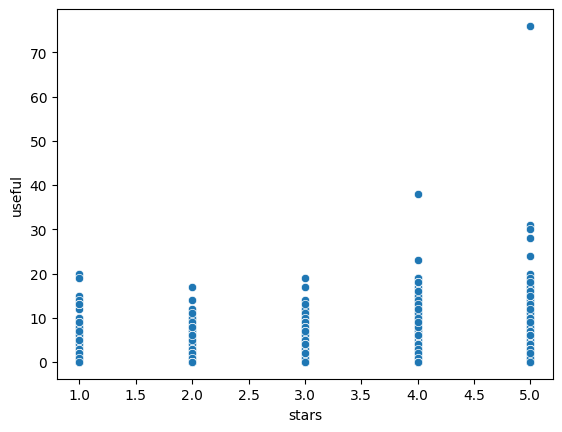

In [73]:
# Afficher un diagramme de dispersion pour comparer la colonne utile et la colonne stars

sns.scatterplot(df_restaurants, x = "stars", y = 'useful')

Quelques commentaires avec les meilleurs notes semblent les plus utiles.
Mais la corrélation est difficile a établir sans la calculer


In [74]:
# Calcul corrélation

correlation = df_restaurants['stars'].corr(df_restaurants['useful'])
print(f"Corrélation Stars/Useful : {correlation}")

Corrélation Stars/Useful : -0.023478955127693917


Il n'y a donc pas de corrélation, à part quelques extrèmes qui "faussent" le ressenti du graphique

<Axes: xlabel='len_text', ylabel='useful'>

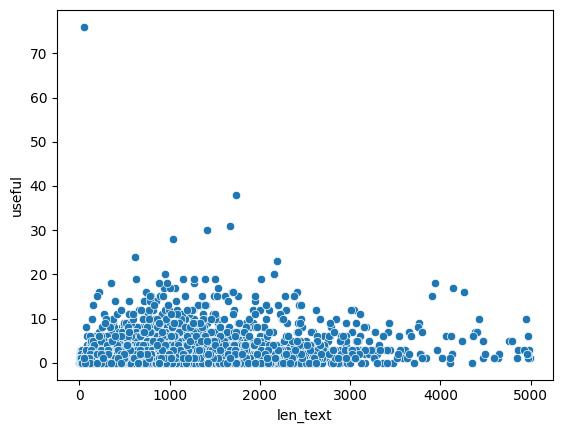

In [90]:
# Idem entre len_text et useful

sns.scatterplot(df_restaurants, x = "len_text", y = 'useful')


In [91]:
# Calcul corrélation

correlation = df_restaurants['len_text'].corr(df_restaurants['useful'])
print(f"Corrélation len_text/Useful : {correlation}")

Corrélation len_text/Useful : 0.29397538215526103


On remarque une corrélation positive modérée entre len_text et useful
Ce qui veut dire que, plus un commentaire est long, plus il semble utile.

# Partie 3: NLP - Classification d'analyse des sentiments - 2h

Définissez `X` qui ne contiendra que la colonne `text`et `y` qui sera la colonne `sentiment`.

In [ ]:
X = df_restaurants['text']
y= df_restaurants['sentiment']

## Créez une fonction pour nettoyer les mots d'arrêt et la ponctuation

Vous pouvez appeler votre fonction `func_clean`.
Votre fonction doit prendre un `str` en tant que paramètre unique et retourner un `str`.

Par exemple:

`func_clean("Hello, how are you? Fine, thank you.")`

`>>> 'hello fine thank'`

In [94]:
!pip install nltk

In [95]:
import nltk
import spacy
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [99]:
nlp = spacy.load('en_core_web_sm')
# Comme on travaille, sur les sentiments, supprimer les negations ne me parait pas pertinent
stopwordsenglish = nltk.corpus.stopwords.words("english")
negations = {"not", "no", "never", "n't","nothing", "neither"}

stopwords_filtered = [word for word in stopwordsenglish if word not in negations]


In [102]:
#Création de la fonction

def func_clean(text) :
  # Spacy découpe automatiquement en tokens avec cette syntaxe :
  sent_tokens = nlp(text)
  # Create list
  words_lemma = [
      token.lemma_.lower()
      for token in sent_tokens
      #Ponctuation
      if not token.is_punct
      #espace
      and not token.is_space
      # mots communs
      and token.lemma_.lower() not in stopwords_filtered
]

  return " ".join(words_lemma)

In [103]:
func_clean("Hello, how are you? Fine, thank you.")

'hello fine thank'

## Appliquer cette fonction

Apply cette fonction à `X` et stockez le résultat dans la variable ` X_clean`.

In [105]:
X_clean = X.apply(func_clean)

In [106]:
X_clean.head(5)

,text
0,wife take birthday breakfast excellent weather...
1,no idea people give bad review place go show p...
2,love gyro plate rice good also dig candy selec...
3,rosie dakota love chaparral dog park convenien...
4,general manager scott petello good egg not go ...


## Split de test de train

Divisez vos données `X_clean` et `y` avec un `train_test_split()`, et le même `random_state = 32`.

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size = 0.2, random_state = 32 , stratify = y) # Stratify pour respeecter les cproportions d'origine

## tfidfvectorizer

- Initialiser votre vectorisateur et stockez le résultat dans `vectorizer`
- Train `vectorizer` sur ` x_train`.
- Train et Transform `x_train` avec votre vectorisateur et stockez le résultat dans `x_train_vecto`.
- Transformez `x_test` avec votre vectorisateur et stockez le résultat dans` x_test_vecto`.

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [150]:
#Initialiser votre vectorisateur et stockez le résultat dans vectorizer. Je mets le parametre ngram_range pour recuperer aussi les negations (au lieu de voir good, voir not good), max_features sinon grid search trop long avec trop de colonnes
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

# # Train vectorizer sur x_train/ Train et Transform x_train avec votre vectorisateur et stockez le résultat dans x_train_vecto
X_train_vecto = vectorizer.fit_transform(X_train)


# Transformez x_test avec votre vectorisateur et stockez le résultat dans x_test_vecto.
# Attention de ne pas train sur le test pour eviter la fuite de donnée (le modele verarit des mots qu'il n'a pas forcément vu)
X_test_vecto = vectorizer.transform(X_test)

## Régression logistique

Entrainez un modèle de régression logistique sur `x_train_vecto` et` y_train`.

Veuillez comparer les scores de précision des ensembles de formation et de test. Y a-t-il un sur-ajustement (`OverFitting)`?

Affichez également une matrice de confusion pour l'ensemble de tests. Combien de «mauvais» commentaires sont correctement prédits?

In [151]:
from sklearn.linear_model import LogisticRegression

model_logistic = LogisticRegression()

model_logistic.fit(X_train_vecto, y_train)


LogisticRegression()

In [152]:
from sklearn.metrics import classification_report

y_test_pred = model_logistic.predict(X_test_vecto)
y_train_pred =  model_logistic.predict(X_train_vecto)

print(f"Classification report logistic test \n\n"
      f"{classification_report(y_test, y_test_pred)}")

print(f"Classification report logistic train \n\n"
      f"{classification_report(y_train, y_train_pred)}")

Classification report logistic test 

              precision    recall  f1-score   support

         bad       0.82      0.62      0.70       627
        good       0.84      0.94      0.89      1373

    accuracy                           0.84      2000
   macro avg       0.83      0.78      0.80      2000
weighted avg       0.84      0.84      0.83      2000

Classification report logistic train 

              precision    recall  f1-score   support

         bad       0.92      0.73      0.81      2510
        good       0.89      0.97      0.93      5490

    accuracy                           0.89      8000
   macro avg       0.90      0.85      0.87      8000
weighted avg       0.90      0.89      0.89      8000



In [153]:
# Calcul uniquement de la précision comme demandé

score_test_log = model_logistic.score(X_test_vecto, y_test)
score_train_log = model_logistic.score(X_train_vecto, y_train)

print(f"Score test Logistic = {score_test_log}")
print(f"Score train Logistic= {score_train_log}")



Score test Logistic = 0.8375
Score train Logistic= 0.894375


Il n'y a que très peu de difference entre le train et le test, pour moi on ne peut pas parler d'overfitting important.

## Arbre de décision
Entrainez un modèle d'arbre de décision sur `x_train_vecto` et` y_train`.

Veuillez comparer les scores de précision des ensembles de formation et de test.Y a-t-il un sur-ajustement?Les scores sont-ils meilleurs qu'auparavant?

In [154]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()

model_tree.fit(X_train_vecto, y_train)

y_test_pred_tree = model_tree.predict(X_test_vecto)
y_train_pred_tree =  model_tree.predict(X_train_vecto)

print(f"Classification report test \n\n"
      f"{classification_report(y_test, y_test_pred_tree)}")

print(f"Classification report train \n\n"
      f"{classification_report(y_train, y_train_pred_tree)}")

Classification report test 

              precision    recall  f1-score   support

         bad       0.53      0.54      0.54       627
        good       0.79      0.78      0.79      1373

    accuracy                           0.71      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.71      0.71      0.71      2000

Classification report train 

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00      2510
        good       1.00      1.00      1.00      5490

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [155]:

score_test_tree = model_tree.score(X_test_vecto, y_test)
score_train_tree= model_tree.score(X_train_vecto, y_train)

print(f"Score test Tree = {score_test_tree}")
print(f"Score train Tree= {score_train_tree}")


Score test Tree = 0.707
Score train Tree= 0.99975


Le modèle a subi un overfitting important. Sur le train, il est a 100% mais s'effondre completement en test
Il a appris sans limite.
Le GridSearch peut limiter ca en testant different parametres pour eviter un "arbre sans fin"

In [158]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30, 50], # profondeur maximale de l'arbre
    'min_samples_split': [2, 10, 20], #nombre minimum d'échantillons pour faire un nœud.
    'criterion': ['gini', 'entropy'] # mesure la qualité d'une division (fonction math)
}

grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', verbose = 2)  # accuracy pour chercher les meilleurs param, cv pour cross validation (fait la moyenne)

grid_tree.fit(X_train_vecto, y_train)

print(f"Meilleurs paramètres : {grid_tree.best_params_}")
print(f"Meilleur score de validation : {grid_tree.best_score_:.3f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   1.3s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   1.2s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   1.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.9s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   1.0s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   0.9s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   0.9s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   0.9s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   0.9s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   1.0s
[CV] END .criterion=gini, max_depth=10, min_samples_split=20; total time=   0.9s
[CV] END .criterion=gini, max_depth=10, min_sam

In [160]:
#Récuperation du best_estimator
best_model_tree = grid_tree.best_estimator_

y_test_pred_grid = best_model_tree.predict(X_test_vecto)
y_train_pred_grid = best_model_tree.predict(X_train_vecto)

score_test_grid = best_model_tree.score(X_test_vecto, y_test)
score_train_grid= best_model_tree.score(X_train_vecto, y_train)

print(f"Score test GridSearch Decision Tree = {score_test_grid}")
print(f"Score train GridSearch Decision Tree = {score_train_grid}")

Score test Logistic = 0.728
Score train Logistic= 0.801375


## Comparaison des algorithmes

Comparez les scores des 2 algorithmes, intéprétez et dites-nous lequel est meilleur selon vous ?

In [157]:
print(f"Score test Logistic = {score_test_log}")
print(f"Score train Logistic= {score_train_log}")
print(f"Score test Tree = {score_test_tree}")
print(f"Score train Tree= {score_train_tree}")

Score test Logistic = 0.8375
Score train Logistic= 0.894375
Score test Tree = 0.707
Score train Tree= 0.99975


Pour la réponse, nous oublions GridSearch qui n'etait pas demandé. De toute facon, ca reste moins bon que la Régression logistique.

Le meilleur modele est la Regression logistique.

Nous voyons directement que l'arbre de décision a eu un overfitting, ce qui fait que ses scores s'ecroulent sur des données inconnues.

# Optionnel: algorithme `json` et manipulation.
Il s'agit d'un fichier JSON contenant plusieurs clés.
Chaque clé a une valeur, qui pourrait potentiellement être une autre clé, contenant une autre valeur, qui pourrait potentiellement être une autre clé, etc.

In [147]:
food = {
  "clé1": {
    "fruit1": "pomme",
    "légume4": "brocoli"
  },
  "clé2": {
    "légume1": "carotte",
    "fruit5": "banane",
    "légume3": "courgette"
  },
  "clé3": {
    "niveau1": {
      "niveau2": {
        "fruit3": "orange",
        "légume5": "aubergine",
        "fruit5": "mangue"
      }
    }
  },
  "clé4": {
    "niveau1": {
      "niveau2": {
        "niveau3": {
          "fruit6": "raisin",
          "fruit7": "fraise",
          "légume4": "poivron",
          "fruit2": "pastèque"
        }
      }
    }
  }
}


Problème:

Les fruits et légumes ont été égarés dans ce fichier JSON. L'objectif est de récupérer chacun des fruits et légumes et de les attribuer à deux listes correspondantes : `fruits_list` & `vegetables_list`.

Solution attendue:

`fruits_list` = `['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque']`

`vegetables_list` = `['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']`


In [148]:
fruits_list = []
vegetables_list = []

def extraire(data):
    for key, value in data.items():
        if type(value) == dict:
            extraire(value)
        elif key[:5] == 'fruit':
            fruits_list.append(value)
        elif key[:6] == 'légume':
            vegetables_list.append(value)

extraire(food)

print(f"fruits_list = {fruits_list}")
print(f"vegetable_list = {vegetables_list}")

fruits_list = ['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque']
vegetable_list = ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']


Ensuite, vous créerez un nouveau dictionnaire, qui contiendra simplement deux clés : «fruits» et «légumes». Chaque clé aura la valeur de la liste des fruits et la liste des légumes.

Solution attendue:

`food_dict` = `{'fruits': ['pomme','banane','orange','mangue','raisin','fraise','pastèque'],
 'legumes': ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']}`

In [149]:
food_dict = {'fruits' : fruits_list, 'legumes' : vegetables_list}
food_dict

{'fruits': ['pomme',
  'banane',
  'orange',
  'mangue',
  'raisin',
  'fraise',
  'pastèque'],
 'legumes': ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']}